In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/johanneskoch/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(150, 2)
(150, 3)


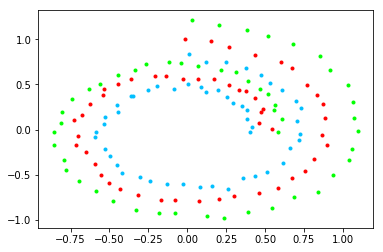

In [2]:
# Generate data

phi_tmp = np.linspace(0, 2.5*np.pi, 50)
x_tmp = np.linspace(0.5, 1, 50)
c0 = np.array([[np.multiply(x_tmp, np.cos(phi_tmp))], [np.multiply(x_tmp, np.sin(phi_tmp))]])
c1 = np.array([[0.8*np.multiply(x_tmp, np.cos(phi_tmp))], [0.8*np.multiply(x_tmp, np.sin(phi_tmp))]])
c2 = np.array([[1.2*np.multiply(x_tmp, np.cos(phi_tmp))], [1.2*np.multiply(x_tmp, np.sin(phi_tmp))]])
c = np.concatenate([c0, c1, c2], axis=2)
c = c.reshape([2, 150])
c += 0.02*np.random.randn(2,150) #add noise
X_data = c.transpose()
Y_data = np.zeros([150, 3])

#One-hot encoding
Y_data[0:50,0] = 1
Y_data[50:100,1] = 1
Y_data[100:150,2] = 1

print(X_data.shape)
print(Y_data.shape)
plt.plot(X_data[0:50,0], X_data[0:50,1], color='r', marker='.', linestyle='None')
plt.plot(X_data[50:100,0], X_data[50:100,1], color='deepskyblue', marker='.', linestyle='None')
plt.plot(X_data[100:150,0], X_data[100:150,1], color='lime', marker='.', linestyle='None')
plt.show()

In [7]:
learning_rate = 0.01
training_epochs = 5000
batch_size = 100
scale = 0.01 #regularizing coefficient
plot_decision_boundary = False

input_dimensions = 2
hidden_units = [10, 10, 10]
output_dimensions = 3 #need to change to softmax for it to work on more than 1 dimensional output
interlayer_activations = "tanh"
if(output_dimensions == 1):
    output_activation = "sigmoid"
else:
    output_activation = "softmax"

X = tf.placeholder("float", [None, input_dimensions])
Y = tf.placeholder("float", [None, output_dimensions])

#Create weigth and bias dictionaries
weights = {'h1': tf.Variable(tf.random_uniform(
    [input_dimensions, hidden_units[0]],
    minval=-6.0/np.sqrt(input_dimensions+hidden_units[0]), 
    maxval=6.0/np.sqrt(input_dimensions+hidden_units[0])))}
for i in range(1,len(hidden_units)):
    weights['h'+str(i+1)] = tf.Variable(tf.random_uniform(
        [hidden_units[i-1], hidden_units[i]],
        minval=-6.0/np.sqrt(hidden_units[i-1]+hidden_units[i]),
        maxval=6.0/np.sqrt(hidden_units[i-1]+hidden_units[i])))
weights['h_out'] = tf.Variable(tf.random_uniform(
    [hidden_units[-1], output_dimensions],
    minval=-6.0/np.sqrt(hidden_units[1]+output_dimensions),
    maxval=6.0/np.sqrt(hidden_units[1]+output_dimensions)))

biases = {'b1': tf.Variable(tf.zeros([hidden_units[0]]))}
for i in range(1,len(hidden_units)):
    biases['b'+str(i+1)] = tf.Variable(tf.zeros([hidden_units[i]]))
biases['b_out'] = tf.Variable(tf.zeros([output_dimensions]))



def multilayer_perceptron(X):
    #Input to layer (X or output from previous layer, is multiplied with the
    #weight matrix, and then the bias is added, finally the output of the layer
    #is the activation function of XW+b, here the sigmoid)
    layers = []
    output_prev_layer = X
    for i in range(len(hidden_units)):
        #if(i==len(hidden_units)-1 and interlayer_activations=="softmax"):
        #    print('adding softmax layer')
        #    layers.append(tf.nn.sigmoid(tf.add(tf.matmul(output_prev_layer, weights['h'+str(i+1)]), biases['b'+str(i+1)])))
        if(interlayer_activations=="tanh"):
            print('adding tanh layer')
            tf.contrib.layers.l2_regularizer(scale)
            #tf.contrib.layers.l2_regularizer(0.1)
            layers.append(tf.nn.relu(tf.add(tf.matmul(output_prev_layer, weights['h'+str(i+1)]), biases['b'+str(i+1)])))
        #output_prev_layer = layers[-1]
        if(interlayer_activations=="sigmoid"):
            print('adding sigmoid layer')
            layers.append(tf.sigmoid(tf.add(tf.matmul(output_prev_layer, weights['h'+str(i+1)]), biases['b'+str(i+1)])))
        output_prev_layer = layers[-1]
    #Note that I didn't include the sigmoid in the output layer, I will
    #add this later in the code
    out_layer = tf.add(tf.matmul(layers[-1], weights['h_out']), biases['b_out'])
    return out_layer
    
logits = multilayer_perceptron(X)

#regularizer = tf.nn.l2_loss(weights)


if(output_activation=="sigmoid"):
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y))
if(output_activation=="softmax"):
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) #make changeable
train_op = optimizer.minimize(loss_op)

#Initializing the variables
init = tf.global_variables_initializer()


adding tanh layer
adding tanh layer
adding tanh layer


In [8]:
X_shuf = X_data.copy()
Y_shuf = Y_data.copy()

sess = tf.Session()
sess.run(init)
for epoch in range(training_epochs):
    random_state = np.random.get_state() #Get the random state to make sure 
                                         #shuffle is done the same for X and Y
    np.random.set_state(random_state)
    np.random.shuffle(X_shuf)
    np.random.set_state(random_state)
    np.random.shuffle(Y_shuf)
    n_minibatches = int(X_data.shape[0]/batch_size) #skip the last part of data if it 
                                                    #doesn't fill up an entire mini-batch
    
    avg_loss = 0.
    for minibatch in range(n_minibatches):
        _,loss = sess.run([train_op, loss_op], feed_dict={
                                                X: X_shuf[minibatch*batch_size:(minibatch+1)*batch_size],
                                                Y: Y_shuf[minibatch*batch_size:(minibatch+1)*batch_size]})
        avg_loss += loss/n_minibatches
    if(epoch%(0.1*training_epochs) == 0):
        print("Training ", str(int(100*epoch/training_epochs)), 
              "% done", "\tEpoch: ", epoch, "\tCost: ", avg_loss)
print("Training 100 % done \tEpoch: ", epoch, "\tCost: ", avg_loss)

Training  0 % done 	Epoch:  0 	Cost:  3.3075156211853027
Training  10 % done 	Epoch:  500 	Cost:  0.25061166286468506
Training  20 % done 	Epoch:  1000 	Cost:  0.04628917574882507
Training  30 % done 	Epoch:  1500 	Cost:  0.006813511718064547
Training  40 % done 	Epoch:  2000 	Cost:  0.0022557161282747984
Training  50 % done 	Epoch:  2500 	Cost:  0.001214668620377779
Training  60 % done 	Epoch:  3000 	Cost:  0.0006377422832883894
Training  70 % done 	Epoch:  3500 	Cost:  0.0003727566509041935
Training  80 % done 	Epoch:  4000 	Cost:  0.00039056927198544145
Training  90 % done 	Epoch:  4500 	Cost:  0.00024009546905290335
Training 100 % done 	Epoch:  4999 	Cost:  0.0001634011568967253


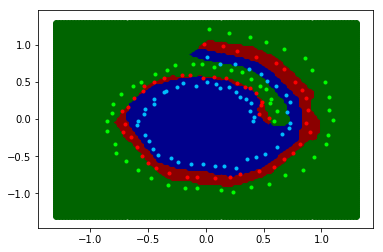

In [9]:
#Plot the result

if(plot_decision_boundary):
    pred = tf.nn.sigmoid(logits)
    correct_prediction = tf.equal(tf.argmax(Y_data,1), tf.argmax(pred,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: X_data, Y:Y_data}))
    prediction = tf.argmax(pred, 1)
    boundary_x = []
    boundary_y = []
    boundary_95_x = []
    boundary_95_y = []
    boundary_05_x = []
    boundary_05_y = []
    allowed_diff = 0.01
    for x_grid in np.linspace(-1, 1, 100):
        for y_grid in np.linspace(-1,1,100):
            prob = pred.eval(feed_dict={
                X: np.reshape(np.array([x_grid, y_grid]), [1,2])},
                             session=sess)
            if(prob>=0.5-allowed_diff and prob<=0.5+allowed_diff):
                boundary_x.append(x_grid)
                boundary_y.append(y_grid)
            if(prob>=0.95-allowed_diff and prob<=0.95+allowed_diff):
                boundary_95_x.append(x_grid)
                boundary_95_y.append(y_grid)
            if(prob>=0.05-allowed_diff and prob<=0.05+allowed_diff):
                boundary_05_x.append(x_grid)
                boundary_05_y.append(y_grid)


    index = Y_shuf == 1

    plt.plot(X_shuf[index[:,0],0], X_shuf[index[:,0],1], 'ro')
    index = Y_shuf == 0
    plt.plot(X_shuf[index[:,0],0], X_shuf[index[:,0],1], 'bx')
    plt.plot(boundary_x, boundary_y, 'c.')
    plt.plot(boundary_95_x, boundary_95_y, 'k.')
    plt.plot(boundary_05_x, boundary_05_y, 'k.')
    plt.show()

else:
    if(output_activation=="sigmoid"):
        pred = tf.nn.sigmoid(logits)
    if(output_activation=="softmax"):
        pred = tf.nn.softmax(logits)
    correct_prediction = tf.equal(tf.argmax(Y_data,1), tf.argmax(pred,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


    boundary_x_0 = []
    boundary_y_0 = []
    boundary_x_1 = []
    boundary_y_1 = []
    boundary_x_2 = []
    boundary_y_2 = []

    #allowed_diff = 0.01
    for x_grid in np.linspace(-1.3, 1.3, 100):
        for y_grid in np.linspace(-1.3,1.3,100):
            prob = pred.eval(feed_dict={
                X: np.reshape(np.array([x_grid, y_grid]), [1,2])},
                             session=sess)
            pred_class = np.argmax(prob)
            if(pred_class == 0):
                boundary_x_0.append(x_grid)
                boundary_y_0.append(y_grid)
                #plt.plot(x_grid, y_grid, 'ro')
            if(pred_class == 1):
                boundary_x_1.append(x_grid)
                boundary_y_1.append(y_grid)
                #plt.plot(x_grid, y_grid, 'bo')
            if(pred_class == 2):
                boundary_x_2.append(x_grid)
                boundary_y_2.append(y_grid)
                #plt.plot(x_grid, y_grid, 'go')


    plt.scatter(boundary_x_0, boundary_y_0, color='darkred')#, marker=',')#, markersize=5)
    plt.scatter(boundary_x_1, boundary_y_1, color='darkblue')#, marker=',')#, markersize=5)
    plt.scatter(boundary_x_2, boundary_y_2, color='darkgreen')#, marker=',')#, markersize=5)
    plt.plot(X_data[0:50,0], X_data[0:50,1], color='r', marker='.', linestyle='None')
    plt.plot(X_data[50:100,0], X_data[50:100,1], color='deepskyblue', marker='.', linestyle='None')
    plt.plot(X_data[100:150,0], X_data[100:150,1], color='lime', marker='.', linestyle='None')

    plt.show()